Merged DataFrame:
            w_c  msd_slope_full  msd_slope_lastN  rdf_peak  c_myOrient1  \
config                                                                    
config_1   0.60        0.001627         0.001627   10.4103     0.039905   
config_2   0.65        0.001354         0.001354   11.0856     0.062729   
config_3   0.70        0.001144         0.001144   11.4771     0.083299   
config_4   0.75        0.000973         0.000973   12.3051     0.100873   
config_5   0.80        0.000937         0.000937   12.9772     0.111470   
config_6   0.85        0.000728         0.000728   13.5761     0.118485   
config_7   0.90        0.000708         0.000708   14.0093     0.122750   
config_8   0.95        0.000720         0.000720   15.2838     0.124315   
config_9   1.00        0.000597         0.000597   16.0183     0.125499   
config_10  1.05        0.000613         0.000613   16.6990     0.124598   
config_11  1.10        0.000537         0.000537   18.6024     0.123306   
config_

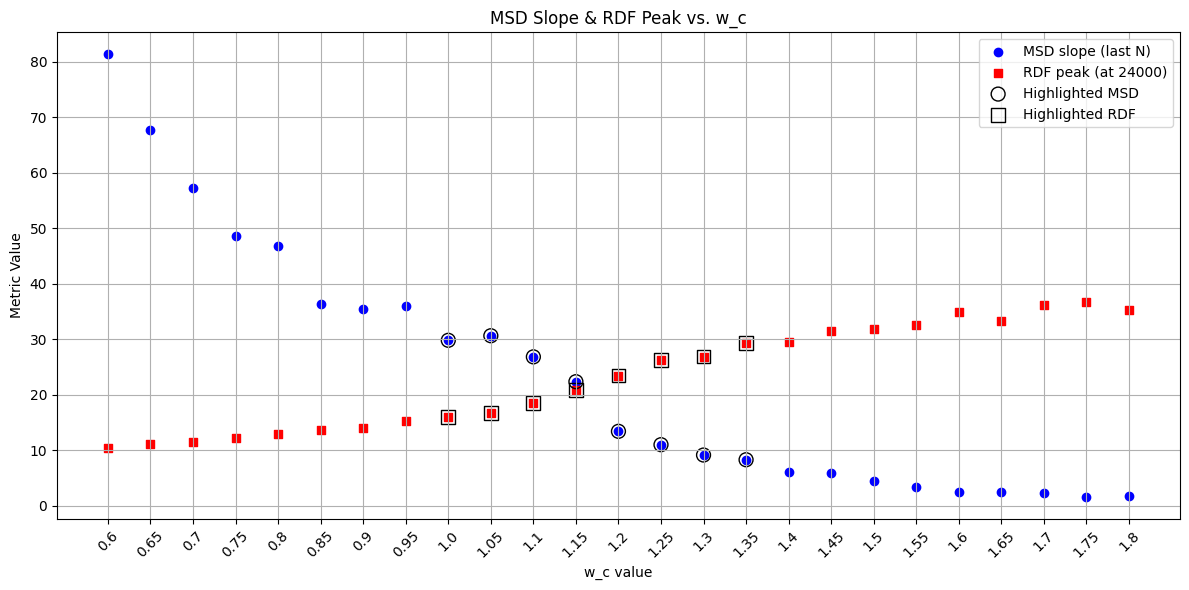

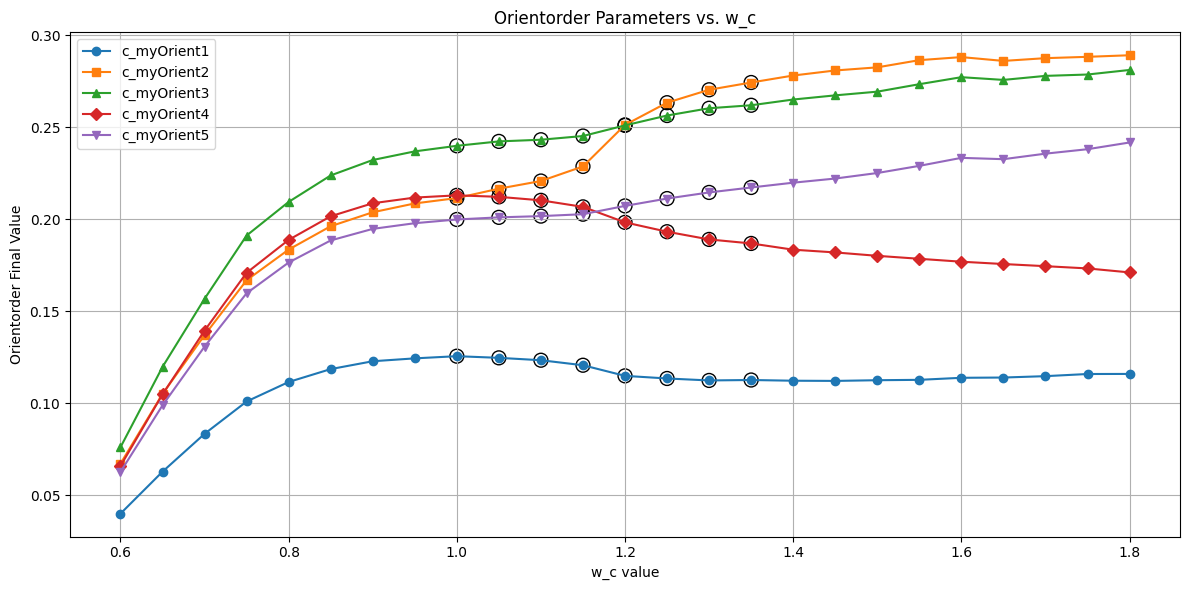

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------
# 0. Load the parameter for labeling (w_c values)
# -----------------------------------------------
wc_df = pd.read_csv("wc_default_samples.csv")
# Assuming wc_default_samples.csv rows correspond to config_1, config_2, etc.
wc_df["config"] = "config_" + (wc_df.index + 1).astype(str)
wc_dict = wc_df.set_index("config")["w_c_default"].to_dict()

# -----------------------------------------------
# 1. List all configuration folders (config_1, config_2, ...)
# -----------------------------------------------
base_dir = "."
configs = [d for d in os.listdir(base_dir)
           if d.startswith("config_") and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split("_")[1]))

# -----------------------------------------------
# 2. Read and compute MSD slopes (over full range and last N steps)
# -----------------------------------------------
msd_slopes_dict = {}
msd_slopes_lastN_dict = {}
N = 15000  # Adjust as needed

for config in configs:
    msd_file = os.path.join(base_dir, config, "msd_adapt.out")
    if not os.path.isfile(msd_file):
        continue

    try:
        # Read MSD file, skipping comment lines.
        msd_df = pd.read_csv(msd_file, comment="#", sep=r"\s+", header=None)
        # Check number of columns and assign column names.
        if msd_df.shape[1] == 2:
            msd_df.columns = ["TimeStep", "v_msd_all_val"]
        elif msd_df.shape[1] == 5:
            msd_df.columns = ["TimeStep", "v_msd_all_val", "v_msd_1_val", "v_msd_8_val", "v_msd_9_val"]
        else:
            raise ValueError(f"Unexpected number of columns in {msd_file}: {msd_df.shape[1]}")

        # Full-range slope of v_msd_all_val vs. TimeStep.
        slope_full, _ = np.polyfit(msd_df["TimeStep"], msd_df["v_msd_all_val"], 1)
        msd_slopes_dict[config] = slope_full

        # Slope over the last N steps.
        subset_df = msd_df.tail(N) if len(msd_df) > N else msd_df
        slope_lastN, _ = np.polyfit(subset_df["TimeStep"], subset_df["v_msd_all_val"], 1)
        msd_slopes_lastN_dict[config] = slope_lastN

    except Exception as e:
        print(f"Error processing {msd_file} in {config}: {e}")
        msd_slopes_dict[config] = np.nan
        msd_slopes_lastN_dict[config] = np.nan

# -----------------------------------------------
# 3. Custom functions for parsing RDF files 
#    (which contain two blocks – one for time 0 and one for time 24000)
# -----------------------------------------------
def parse_rdf_block(filepath, target_timestep=24000):
    """
    Parses an RDF file with multiple blocks.  
    Each block begins with a header line containing:
        TimeStep  Number-of-rows
    Followed by that number of rows, each containing four numbers:
        Row_index  c_myRDF[1]  c_myRDF[2]  c_myRDF[3]
    Returns a DataFrame for the block matching target_timestep.
    """
    with open(filepath, "r") as f:
        # Read non-empty, non-comment lines.
        lines = [line.strip() for line in f if line.strip() and not line.startswith("#")]
    
    i = 0
    while i < len(lines):
        parts = lines[i].split()
        # Expect header lines to have exactly 2 fields.
        if len(parts) == 2:
            try:
                block_time = float(parts[0])
                num_rows = int(parts[1])
            except Exception as e:
                print(f"Error reading header line in {filepath}: {lines[i]}, {e}")
                i += 1
                continue

            # If this block matches our target time step, parse it.
            if block_time == target_timestep:
                data_rows = []
                for j in range(i+1, i+1+num_rows):
                    if j < len(lines):
                        row_data = [float(x) for x in lines[j].split()]
                        data_rows.append(row_data)
                # Create DataFrame.
                df = pd.DataFrame(data_rows, columns=["bin", "c_myRDF[1]", "c_myRDF[2]", "c_myRDF[3]"])
                return df
            else:
                # Skip this block.
                i += 1 + num_rows
        else:
            i += 1
    return None

def get_rdf_peak_from_file(filepath, target_timestep=24000, col="c_myRDF[2]"):
    """
    Returns the maximum value from the specified RDF column in the block corresponding to target_timestep.
    """
    rdf_df = parse_rdf_block(filepath, target_timestep)
    if rdf_df is None or rdf_df.empty:
        return np.nan
    return rdf_df[col].max()

rdf_peak_dict = {}
for config in configs:
    rdf_file = os.path.join(base_dir, config, "rdf_adapt.out")
    if not os.path.isfile(rdf_file):
        rdf_peak_dict[config] = np.nan
        continue

    try:
        peak_val = get_rdf_peak_from_file(rdf_file, target_timestep=24000, col="c_myRDF[2]")
        rdf_peak_dict[config] = peak_val
    except Exception as e:
        print(f"Error processing {rdf_file} in {config}: {e}")
        rdf_peak_dict[config] = np.nan

# -----------------------------------------------
# 4. Read orientorder.out and store each parameter separately.
#    We store final values for c_myOrient1..c_myOrient5.
# -----------------------------------------------
orient_params = { "c_myOrient1": {},
                  "c_myOrient2": {},
                  "c_myOrient3": {},
                  "c_myOrient4": {},
                  "c_myOrient5": {} }

for config in configs:
    orient_file = os.path.join(base_dir, config, "orientorder.out")
    if not os.path.isfile(orient_file):
        for key in orient_params:
            orient_params[key][config] = np.nan
        continue

    try:
        ori_df = pd.read_csv(orient_file, comment="#", sep=r"\s+", header=None)
        ori_df.columns = ["TimeStep", "c_myOrient1", "c_myOrient2", "c_myOrient3", "c_myOrient4", "c_myOrient5"]
        final_row = ori_df.iloc[-1]
        for col in orient_params.keys():
            orient_params[col][config] = final_row[col]
    except Exception as e:
        print(f"Error processing {orient_file} in {config}: {e}")
        for col in orient_params.keys():
            orient_params[col][config] = np.nan

# -----------------------------------------------
# 5. Combine all metrics into a single DataFrame.
# -----------------------------------------------
all_data = []
for config in configs:
    entry = {
        "config": config,
        "w_c": wc_dict.get(config, np.nan),
        "msd_slope_full": msd_slopes_dict.get(config, np.nan),
        "msd_slope_lastN": msd_slopes_lastN_dict.get(config, np.nan),
        "rdf_peak": rdf_peak_dict.get(config, np.nan)
    }
    # Add each orientorder parameter.
    for col in orient_params.keys():
        entry[col] = orient_params[col].get(config, np.nan)
    all_data.append(entry)

merged_df = pd.DataFrame(all_data)
merged_df.set_index("config", inplace=True)
print("Merged DataFrame:")
print(merged_df)

# -----------------------------------------------
# 6. Plotting MSD slope and RDF peak with highlighted w_c points.
# -----------------------------------------------
# Create a version of the DataFrame with a reset index to get numerical ordering.
df_plot = merged_df.reset_index()
x_vals = np.arange(len(df_plot))
wc_labels = df_plot["w_c"].round(3).astype(str)

plt.figure(figsize=(12, 6))

# Plot MSD slope (scaled for visibility).
plt.scatter(x_vals, df_plot["msd_slope_lastN"] * 50000, label="MSD slope (last N)", color="blue", marker="o")

# Plot RDF peak.
plt.scatter(x_vals, df_plot["rdf_peak"], label="RDF peak (at 24000)", color="red", marker="s")

# Create highlight mask for w_c between 1.0 and 1.4 (inclusive).
highlight_mask = (df_plot["w_c"] >= 1.0) & (df_plot["w_c"] <= 1.4)

# Overlay highlight markers for MSD slope.
plt.scatter(x_vals[highlight_mask], 
            df_plot.loc[highlight_mask, "msd_slope_lastN"] * 50000,
            s=100, facecolors='none', edgecolors='k', label="Highlighted MSD")

# Overlay highlight markers for RDF peak.
plt.scatter(x_vals[highlight_mask], 
            df_plot.loc[highlight_mask, "rdf_peak"],
            s=100, facecolors='none', edgecolors='k', marker="s", label="Highlighted RDF")

plt.xticks(x_vals, wc_labels, rotation=45)
plt.xlabel("w_c value")
plt.ylabel("Metric Value")
plt.title("MSD Slope & RDF Peak vs. w_c")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 7. Plotting orientorder parameters.
#     Separate line for each orientorder parameter and highlight points with w_c between 1.0 and 1.4.
# -----------------------------------------------
# Sort the merged DataFrame by w_c for a cleaner line plot.
merged_sorted = merged_df.sort_values("w_c")
wcs = merged_sorted["w_c"]

plt.figure(figsize=(12, 6))
# Define markers for distinction.
markers = {'c_myOrient1': 'o', 'c_myOrient2': 's', 'c_myOrient3': '^', 'c_myOrient4': 'D', 'c_myOrient5': 'v'}

# For each orientorder parameter, plot a line.
for col in ["c_myOrient1", "c_myOrient2", "c_myOrient3", "c_myOrient4", "c_myOrient5"]:
    plt.plot(wcs, merged_sorted[col], label=col, marker=markers[col])
    # Identify points where w_c is between 1.0 and 1.4 and highlight them.
    highlight_mask = (merged_sorted["w_c"] >= 1.0) & (merged_sorted["w_c"] <= 1.4)
    plt.scatter(merged_sorted.loc[highlight_mask, "w_c"],
                merged_sorted.loc[highlight_mask, col],
                s=100, facecolors='none', edgecolors='k')  # large open black circles

plt.xlabel("w_c value")
plt.ylabel("Orientorder Final Value")
plt.title("Orientorder Parameters vs. w_c")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Processing ./config_1/full_traj.lammpstrj ...
Processing ./config_2/full_traj.lammpstrj ...
Processing ./config_3/full_traj.lammpstrj ...
Processing ./config_4/full_traj.lammpstrj ...
Processing ./config_5/full_traj.lammpstrj ...
Processing ./config_6/full_traj.lammpstrj ...
Processing ./config_7/full_traj.lammpstrj ...
Processing ./config_8/full_traj.lammpstrj ...
Processing ./config_9/full_traj.lammpstrj ...
Processing ./config_10/full_traj.lammpstrj ...
Processing ./config_11/full_traj.lammpstrj ...
Processing ./config_12/full_traj.lammpstrj ...
Processing ./config_13/full_traj.lammpstrj ...
Processing ./config_14/full_traj.lammpstrj ...
Processing ./config_15/full_traj.lammpstrj ...
Processing ./config_16/full_traj.lammpstrj ...
Processing ./config_17/full_traj.lammpstrj ...
Processing ./config_18/full_traj.lammpstrj ...
Processing ./config_19/full_traj.lammpstrj ...
Processing ./config_20/full_traj.lammpstrj ...
Processing ./config_21/full_traj.lammpstrj ...
Processing ./config_22

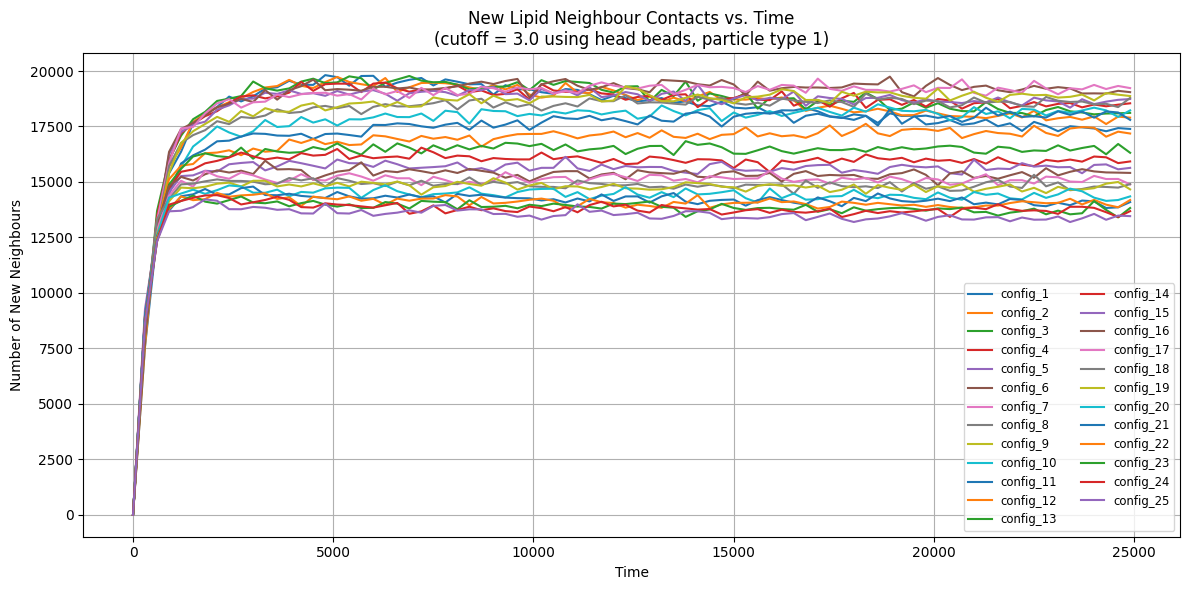

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# --- Function to read a LAMMPS trajectory file ---
def read_lammps_traj(filename):
    """
    Reads a LAMMPS trajectory file in dump format.
    
    Assumes the standard format:
      ITEM: TIMESTEP
      <timestep>
      ITEM: NUMBER OF ATOMS
      <natoms>
      ITEM: BOX BOUNDS ...        (three lines)
      ...
      ITEM: ATOMS id type x y z   (at least these 5 columns)
    
    Returns a list of frames.
    Each frame is a dictionary with keys:
         'time': timestep (int)
         'positions': numpy array of shape (N, 3) for the positions of particles
                      of particle type 1 (head beads).
    """
    frames = []
    with open(filename, 'r') as f:
        while True:
            # --- Read header for timestep ---
            line = f.readline()
            if not line:
                break  # EOF reached
            if "ITEM: TIMESTEP" in line:
                timestep = int(f.readline().strip())
            else:
                continue

            # --- Read number of atoms ---
            f.readline()  # "ITEM: NUMBER OF ATOMS"
            natoms = int(f.readline().strip())

            # --- Skip box bounds (3 lines) ---
            f.readline()  # "ITEM: BOX BOUNDS ..."
            for _ in range(3):
                f.readline()
                
            # --- Read atom data ---
            header = f.readline()  # "ITEM: ATOMS id type x y z ..." 
            atom_data = []
            for i in range(natoms):
                line = f.readline().strip()
                if not line:
                    break
                atom_data.append(line.split())
            
            # --- Filter out only head beads (particle type == 1) ---
            positions = []
            for row in atom_data:
                # Assumes that the second column is the atom type.
                # Adjust column indices if your trajectory has extra columns.
                if int(row[1]) == 1:
                    x = float(row[2])
                    y = float(row[3])
                    z = float(row[4])
                    positions.append([x, y, z])
            frames.append({'time': timestep, 'positions': np.array(positions)})
    return frames

# --- Function to compute neighbor pairs ---
def compute_neighbor_pairs(positions, cutoff=3.0):
    """
    Given a numpy array of positions (shape (N, 3)), returns a set of unique 
    unordered pairs (as tuples) of indices (i, j) (with i < j) that are within 
    the given cutoff distance.
    """
    if len(positions) == 0:
        return set()
    tree = cKDTree(positions)
    pairs = tree.query_pairs(r=cutoff)
    return pairs

# --- Loop through all configurations ---
base_dir = "."  # adjust if needed
configs = [d for d in os.listdir(base_dir)
           if d.startswith("config_") and os.path.isdir(os.path.join(base_dir, d))]
configs.sort(key=lambda x: int(x.split("_")[1]))

# Dictionary to store time and new neighbour counts for each config.
neighbor_changes_by_config = {}

# Iterate over each configuration folder.
for config in configs:
    traj_file = os.path.join(base_dir, config, "full_traj.lammpstrj")  # adjust filename if needed
    if not os.path.isfile(traj_file):
        print(f"Trajectory file not found for {config}")
        continue

    print(f"Processing {traj_file} ...")
    frames = read_lammps_traj(traj_file)
    if len(frames) == 0:
        continue

    times = []
    new_neighbors = []
    previous_pairs = None  # will hold neighbor pairs from the previous time step

    # Loop over frames in the trajectory.
    for frame in frames:
        t = frame['time']
        positions = frame['positions']
        # Compute the set of neighbor pairs (as index pairs) at this frame.
        current_pairs = compute_neighbor_pairs(positions, cutoff=3.0)
        
        if previous_pairs is None:
            # For the first frame, there are no "new" pairs to compare.
            new_count = 0
        else:
            # New neighbors are pairs that appear in the current frame but were not present in the previous frame.
            new_pairs = current_pairs - previous_pairs
            new_count = len(new_pairs)
        
        times.append(t)
        new_neighbors.append(new_count)
        previous_pairs = current_pairs  # update for next iteration

    neighbor_changes_by_config[config] = (np.array(times), np.array(new_neighbors))

# --- Plotting new neighbor counts for each config ---
plt.figure(figsize=(12, 6))
for config, (times, new_counts) in neighbor_changes_by_config.items():
    plt.plot(times, new_counts, label=config)

plt.xlabel("Time")
plt.ylabel("Number of New Neighbours")
plt.title("New Lipid Neighbour Contacts vs. Time\n(cutoff = 3.0 using head beads, particle type 1)")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
merged_sorted

,w_c,msd_slope_full,msd_slope_lastN,rdf_peak,c_myOrient1,c_myOrient2,c_myOrient3,c_myOrient4,c_myOrient5,msd/rdf,rdf/msd
config,,,,,,,,,,,
config_1,0.60,0.001627,0.001627,10.4103,0.039905,0.067075,0.076004,0.065821,0.062621,0.156259,NaN
config_2,0.65,0.001354,0.001354,11.0856,0.062729,0.104993,0.119673,0.104760,0.098786,0.122113,NaN
config_3,0.70,0.001144,0.001144,11.4771,0.083299,0.136951,0.156706,0.139408,0.130705,0.099689,NaN
config_4,0.75,0.000973,0.000973,12.3051,0.100873,0.166792,0.191083,0.170834,0.159709,0.079089,NaN
config_5,0.80,0.000937,0.000937,12.9772,0.111470,0.183452,0.209353,0.188720,0.176419,0.072228,NaN
config_6,0.85,0.000728,0.000728,13.5761,0.118485,0.196148,0.223747,0.201552,0.188416,0.053620,NaN
config_7,0.90,0.000708,0.000708,14.0093,0.122750,0.203719,0.232127,0.208627,0.194696,0.050546,NaN
config_8,0.95,0.000720,0.000720,15.2838,0.124315,0.208527,0.236823,0.211704,0.197779,0.047110,NaN
config_9,1.00,0.000597,0.000597,16.0183,0.125499,0.211443,0.239849,0.212923,0.199802,0.037239,NaN


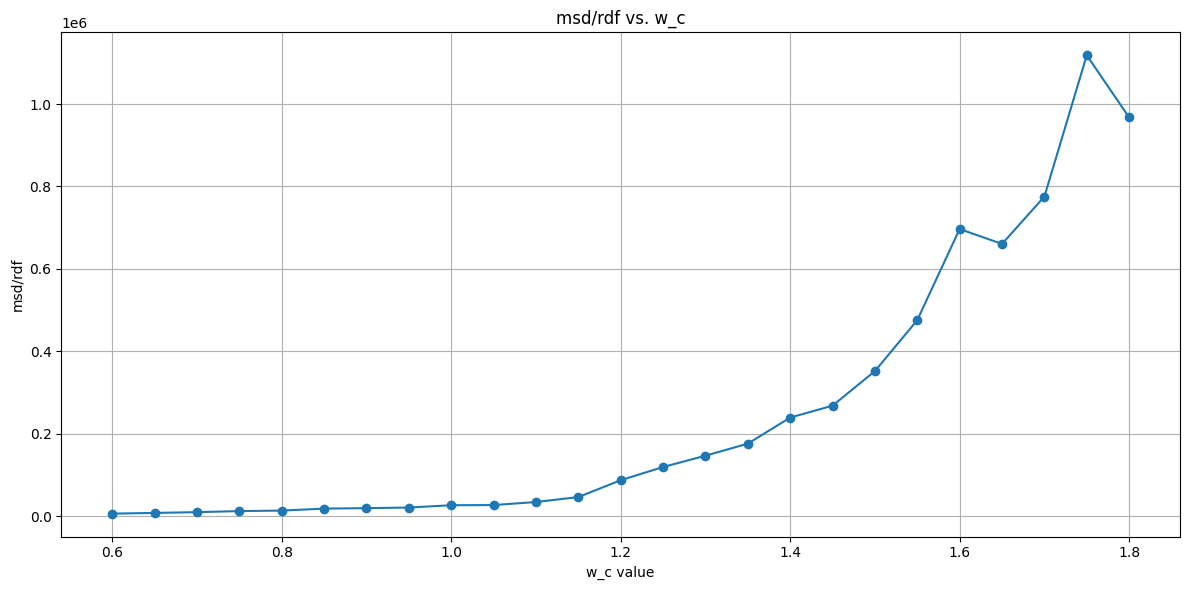

In [35]:
merged_sorted['rdf/msd'] = merged_sorted['rdf_peak'] / merged_sorted['msd_slope_lastN']
plt.figure(figsize=(12, 6))
plt.plot(merged_sorted['w_c'], merged_sorted['rdf/msd'], marker='o')
plt.xlabel("w_c value")
plt.ylabel("msd/rdf")
plt.title("msd/rdf vs. w_c")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import networkx as nx
from scipy.spatial import cKDTree

merged_df = merged_sorted


# --- CONFIGURATION ---
CONFIG_ROOT = "."  # Parent folder containing config_* folders
DATA_FILE = "bilayer.data"
TRAJ_FILE = "full_traj.lammpstrj"
FRAME = -1           # Use the last frame of the trajectory
CUTOFF = 6.0        # Cutoff distance (adjust units as needed)

# --- GROUPING BEADS INTO LIPIDS ---
def group_lipids(u):
    """
    Build a graph from the bonds in the Universe.
    Each connected component of the graph is assumed to be one lipid.
    """
    G = nx.Graph()
    for atom in u.atoms:
        G.add_node(atom.index)
    if hasattr(u, 'bonds'):
        for bond in u.bonds:
            i = bond.atoms[0].index
            j = bond.atoms[1].index
            G.add_edge(i, j)
    else:
        raise RuntimeError("No bond information found in Universe. "
                           "Make sure your LAMMPS data file includes bonds.")
    # Each connected component represents a lipid
    lipid_components = list(nx.connected_components(G))
    # Optionally, filter components by size (here, require at least 3 atoms)
    lipid_components = [comp for comp in lipid_components if len(comp) >= 3]
    return lipid_components

def compute_com_for_lipid(u, indices):
    """
    Compute the center-of-mass for a lipid defined by a set of atom indices.
    Assumes equal mass for simplicity.
    """
    positions = np.array([u.atoms[i].position for i in indices])
    return positions.mean(axis=0)

# --- LOCAL TANGENT PLANE CONSTRUCTION ---
def local_tangent_basis(r):
    """
    Given a radial vector r from the sphere center, compute two perpendicular unit
    vectors (e1, e2) spanning the tangent plane at that point.
    """
    r_norm = np.linalg.norm(r)
    if r_norm < 1e-8:
        raise ValueError("Zero radial vector encountered!")
    r_unit = r / r_norm
    # Choose an arbitrary vector not parallel to r_unit
    arbitrary = np.array([1, 0, 0]) if abs(r_unit[0]) < 0.9 else np.array([0, 1, 0])
    # Remove the component along r_unit
    e1 = arbitrary - np.dot(arbitrary, r_unit) * r_unit
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(r_unit, e1)
    return e1, e2

# --- HEXATIC ORDER CALCULATION USING LIPID COMs ---
def compute_hexatic_order_lipids(datafile, trajfile, cutoff=CUTOFF, frame=FRAME):
    """
    Load the LAMMPS data (and trajectory) and compute the hexatic order parameter
    for the lipid COMs. The procedure is:
      1. Group atoms into lipids using bond connectivity.
      2. Compute COM of each lipid.
      3. Estimate the global sphere center as the mean of COMs.
      4. For each lipid, define a local tangent plane (based on its radial vector)
         and compute angles to its neighbors (found via a KDTree).
      5. Calculate the local sixfold order parameter ψ₆ and average over lipids.
    """
    # Load Universe (using the LAMMPSDUMP format)
    u = mda.Universe(datafile, trajfile, format="LAMMPSDUMP")
    u.trajectory[frame]  # select the desired frame

    # Group beads into lipids using bond connectivity
    lipid_components = group_lipids(u)

    # Compute COM positions for each lipid
    lipid_COMs = []
    for comp in lipid_components:
        com = compute_com_for_lipid(u, comp)
        lipid_COMs.append(com)
    lipid_COMs = np.array(lipid_COMs)

    # Estimate the sphere center as the mean COM position
    center = lipid_COMs.mean(axis=0)

    # Build a KDTree for neighbor search among lipid COMs
    tree = cKDTree(lipid_COMs)
    n_lipids = len(lipid_COMs)

    psi6_values = []
    for i in range(n_lipids):
        pos_i = lipid_COMs[i]
        # Radial vector for lipid i
        r_vec = pos_i - center
        try:
            e1, e2 = local_tangent_basis(r_vec)
        except ValueError:
            continue  # skip if something goes wrong
        # Find the 7 nearest neighbors (including self)
        dists, indices = tree.query(pos_i, k=7)
        neighbor_angles = []
        for dist, j in zip(dists[1:], indices[1:]):  # skip self (first element)
            if dist > cutoff:
                continue
            pos_j = lipid_COMs[j]
            disp = pos_j - pos_i
            # Project disp onto the local tangent plane
            r_unit = r_vec / np.linalg.norm(r_vec)
            proj = disp - np.dot(disp, r_unit) * r_unit
            # Express in local basis (e1, e2)
            x_proj = np.dot(proj, e1)
            y_proj = np.dot(proj, e2)
            angle = np.arctan2(y_proj, x_proj)
            neighbor_angles.append(angle)
        if len(neighbor_angles) == 0:
            psi6_values.append(0.0)
        else:
            op_complex = np.mean(np.exp(1j * 6 * np.array(neighbor_angles)))
            psi6_values.append(np.abs(op_complex))
    if len(psi6_values) == 0:
        return np.nan
    return np.mean(psi6_values)

# --- BATCH ANALYSIS OVER CONFIG FOLDERS ---
def batch_hexatic(config_root):
    results = []
    # Loop over items in the config_root directory
    for item in sorted(os.listdir(config_root)):
        folder = os.path.join(config_root, item)
        # Only consider directories that contain both data and trajectory files
        data_path = os.path.join(folder, DATA_FILE)
        traj_path = os.path.join(folder, TRAJ_FILE)
        if not (os.path.isdir(folder) and os.path.isfile(data_path) and os.path.isfile(traj_path)):
            continue
        try:
            psi6_val = compute_hexatic_order_lipids(data_path, traj_path)
            results.append((item, psi6_val))
            print(f"Config {item}: psi6 = {psi6_val:.4f}")
        except Exception as e:
            print(f"[!] Failed on {item}: {e}")
            results.append((item, np.nan))
    return pd.DataFrame(results, columns=["config", "psi6"])

# --- MERGE WITH EXISTING merged_df ---
# Assume merged_df is already saved/loaded (e.g., via CSV)

# Run the batch hexatic analysis over all configs in CONFIG_ROOT
df_hexatic = batch_hexatic(CONFIG_ROOT)

# Merge hexatic data into merged_df (based on config folder names)
merged_df = merged_df.merge(df_hexatic, on="config", how="left")
merged_df.to_csv("merged_df_with_hexatic.csv", index=False)
print("Merged hexatic order (psi6) into merged_df and saved to 'merged_df_with_hexatic.csv'.")

# --- OPTIONAL: Plot psi6 Only ---
configs = merged_df['config']
x = np.arange(len(merged_df))

plt.figure(figsize=(10, 5))
plt.bar(x, merged_df['psi6'], color='blue', alpha=0.7)
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order Parameter (ψ₆) Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (gel-like?)')
plt.legend()
plt.tight_layout()
plt.show()


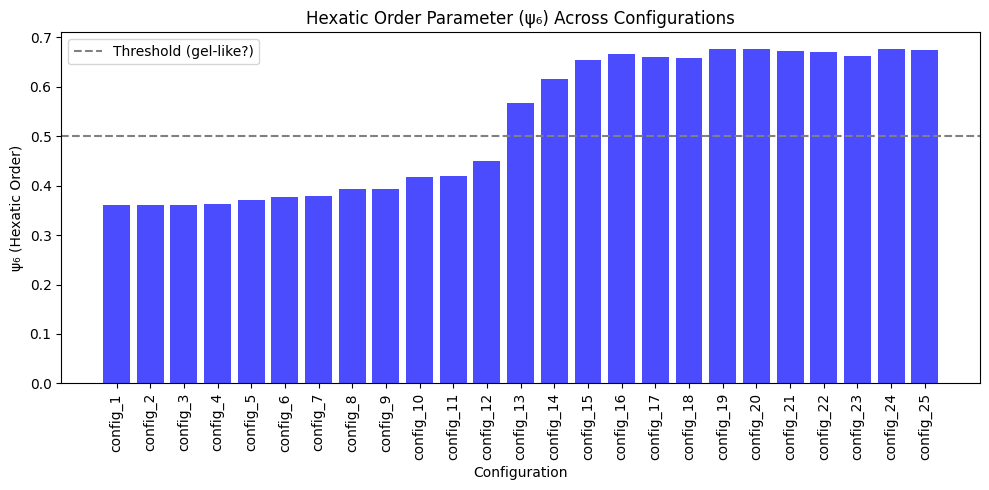

In [24]:
# --- OPTIONAL: Plot psi6 Only ---
configs = merged_df['config']
x = np.arange(len(merged_df))

plt.figure(figsize=(10, 5))
plt.bar(x, merged_df['psi6'], color='blue', alpha=0.7)
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order Parameter (ψ₆) Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (gel-like?)')
plt.legend()
plt.tight_layout()
plt.show()

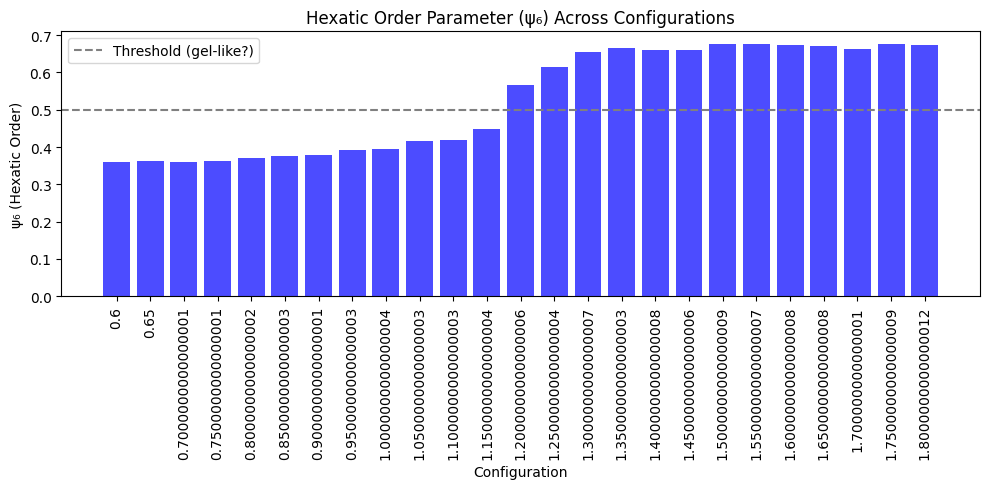

In [26]:
# --- OPTIONAL: Plot psi6 Only ---
configs = merged_df['w_c']
x = np.arange(len(merged_df))

plt.figure(figsize=(10, 5))
plt.bar(x, merged_df['psi6'], color='blue', alpha=0.7)
plt.xticks(x, configs, rotation=90)
plt.xlabel("Configuration")
plt.ylabel("ψ₆ (Hexatic Order)")
plt.title("Hexatic Order Parameter (ψ₆) Across Configurations")
plt.axhline(0.5, color='gray', linestyle='--', label='Threshold (gel-like?)')
plt.legend()
plt.tight_layout()
plt.show()
